In [1]:
# -----------------------------------------------------------
# CELL 0: INSTALL (Run First & Restart)
# -----------------------------------------------------------
!pip install -q "monai" "protobuf==3.20.3" "segmentation-models-pytorch"

print("\n✅ Installation Complete.")
print("⚠️ CRITICAL STEP: Please RESTART THE SESSION now.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
print(f"🔥 Is GPU working? {torch.cuda.is_available()}")
print(f"   GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

🔥 Is GPU working? True
   GPU Name: Tesla T4


In [3]:
# -----------------------------------------------------------
# CELL 1: IMPORTS & SETUP
# -----------------------------------------------------------
import os
import glob
import gc
import numpy as np
import matplotlib.pyplot as plt
import cv2
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

# MONAI Imports for Segmentation
from monai.networks.nets import BasicUNet
from monai.losses import DiceLoss

pl.seed_everything(42)
print("✅ Imports complete. Ready for SEGMENTATION.")

<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-12-21 17:16:35.194352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766337395.407146      21 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766337395.470202      21 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Seed set to 42


✅ Imports complete. Ready for SEGMENTATION.


In [4]:
# -----------------------------------------------------------
# CELL 2: DATA LOADING - FIXED WITH TEST SET
# -----------------------------------------------------------
import os
import glob
import h5py
import torch
import numpy as np
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split

NUM_WORKERS = 0
BATCH_SIZE = 64

def find_file(keyword):
    files = glob.glob(f"/kaggle/input/**/*{keyword}*", recursive=True)
    if not files:
        raise FileNotFoundError(f"Missing {keyword} files")
    files.sort()
    return files[0]

xpath = find_file("split_train_x")
ypath = find_file("split_train_mask")
print(f"✅ Found Images: {os.path.basename(xpath)}")

class CamelyonSegmentationDataset(Dataset):
    def __init__(self, xpath, ypath, transform=None):
        self.xpath = xpath
        self.ypath = ypath
        self.transform = transform
        
        with h5py.File(self.xpath, 'r') as f:
            self.xkey = list(f.keys())[0]
            self.length = len(f[self.xkey])
        
        with h5py.File(self.ypath, 'r') as f:
            self.ykey = list(f.keys())[0]
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        with h5py.File(self.xpath, 'r') as f:
            image = f[self.xkey][idx][...]
        
        with h5py.File(self.ypath, 'r') as f:
            mask = f[self.ykey][idx][...]
        
        if mask.ndim == 3:
            mask = mask.squeeze(-1)
        
        # Convert to tensor
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        mask = torch.from_numpy(mask).unsqueeze(0).float()
        
        # Resize
        resize = T.Resize((224, 224), antialias=True)
        image = resize(image)
        mask = resize(mask)
        mask = (mask > 0.5).float()
        
        return image, mask

# Initialize full dataset
fulldataset = CamelyonSegmentationDataset(xpath, ypath)
total_len = len(fulldataset)

# Split: 70% train, 15% val, 15% test
train_len = int(0.70 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len

print(f"📊 Dataset Split:")
print(f"   Train: {train_len} samples ({train_len/total_len*100:.1f}%)")
print(f"   Val:   {val_len} samples ({val_len/total_len*100:.1f}%)")
print(f"   Test:  {test_len} samples ({test_len/total_len*100:.1f}%)")

# Create splits
train_dataset, val_dataset, test_dataset = random_split(
    fulldataset, 
    [train_len, val_len, test_len]
)

# Create dataloaders
trainloader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS
)

valloader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)

testloader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)

print(f"✅ Data Loaded | Batch Size: {BATCH_SIZE}")
print(f"   Train batches: {len(trainloader)}")
print(f"   Val batches:   {len(valloader)}")
print(f"   Test batches:  {len(testloader)}")


✅ Found Images: camelyonpatch_level_2_split_train_x-002 (1).h5
📊 Dataset Split:
   Train: 183500 samples (70.0%)
   Val:   39321 samples (15.0%)
   Test:  39323 samples (15.0%)
✅ Data Loaded | Batch Size: 64
   Train batches: 2868
   Val batches:   615
   Test batches:  615


Batch Shape - Images: torch.Size([64, 3, 224, 224]), Masks: torch.Size([64, 1, 224, 224])


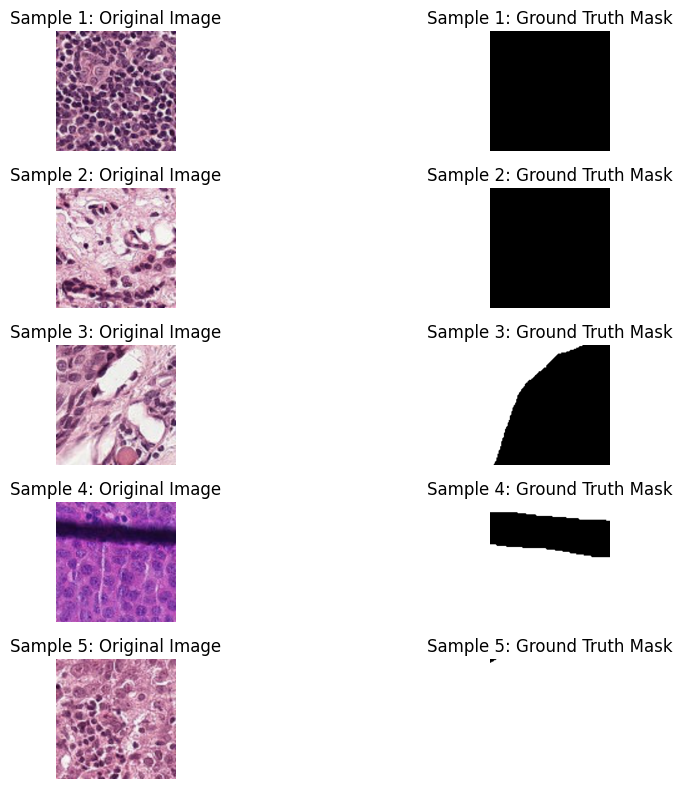

In [5]:
# -----------------------------------------------------------
# CELL 2.5: CHECK DATA & MASKS
# -----------------------------------------------------------
import matplotlib.pyplot as plt

# 1. Get a single batch of data
data_iter = iter(trainloader)  # Fixed: trainloader not train_loader
images, masks = next(data_iter)

print(f"Batch Shape - Images: {images.shape}, Masks: {masks.shape}")

# 2. Plot the first 5 samples
plt.figure(figsize=(12, 8))
for i in range(min(5, len(images))):
    
    # --- Prepare Image ---
    # Convert from Tensor (C, H, W) to Numpy (H, W, C) for plotting
    img_display = images[i].permute(1, 2, 0).numpy()
    
    # --- Prepare Mask ---
    # Squeeze to remove the channel dim: (1, 224, 224) -> (224, 224)
    mask_display = masks[i].squeeze().numpy()
    
    # Plot Original Image
    ax = plt.subplot(5, 2, 2*i + 1)
    ax.imshow(img_display)
    ax.set_title(f'Sample {i+1}: Original Image')
    ax.axis('off')
    
    # Plot Corresponding Mask
    ax = plt.subplot(5, 2, 2*i + 2)
    ax.imshow(mask_display, cmap='gray')
    ax.set_title(f'Sample {i+1}: Ground Truth Mask')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [6]:
# -----------------------------------------------------------
# CELL 3: MODEL DEFINITION (MobileNetV2 U-Net)
# -----------------------------------------------------------
import pytorch_lightning as pl
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp

class MobileNetUNet(pl.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        
        # U-Net with MobileNetV2 encoder
        self.model = smp.Unet(
            encoder_name="mobilenet_v2",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1
        )
        
        # Loss functions
        self.lossfn = smp.losses.DiceLoss(mode='binary', from_logits=True)
        self.bceloss = nn.BCEWithLogitsLoss()
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        
        # Hybrid loss: Dice + BCE
        dice_loss = self.lossfn(logits, y)
        bce_loss = self.bceloss(logits, y)
        loss = 0.5 * dice_loss + 0.5 * bce_loss
        
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_dice', dice_loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        
        # Calculate losses
        dice_loss = self.lossfn(logits, y)
        bce_loss = self.bceloss(logits, y)
        loss = 0.5 * dice_loss + 0.5 * bce_loss
        
        # Calculate Dice score (for monitoring)
        preds = torch.sigmoid(logits)
        preds = (preds > 0.5).float()
        
        intersection = (preds * y).sum()
        union = preds.sum() + y.sum()
        dice_score = (2. * intersection) / (union + 1e-8)
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_dice_loss', dice_loss)
        self.log('val_dice_score', dice_score, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        """Test step - same as validation but logged separately"""
        x, y = batch
        logits = self(x)
        
        # Calculate losses
        dice_loss = self.lossfn(logits, y)
        bce_loss = self.bceloss(logits, y)
        loss = 0.5 * dice_loss + 0.5 * bce_loss
        
        # Calculate metrics
        preds = torch.sigmoid(logits)
        preds = (preds > 0.5).float()
        
        intersection = (preds * y).sum()
        union = preds.sum() + y.sum()
        dice_score = (2. * intersection) / (union + 1e-8)
        iou = intersection / (union - intersection + 1e-8)
        
        correct = (preds == y).sum()
        total = y.numel()
        accuracy = correct / total
        
        # Log all metrics
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_dice_score', dice_score, prog_bar=True)
        self.log('test_iou', iou, prog_bar=True)
        self.log('test_accuracy', accuracy)
        
        return {
            'test_loss': loss,
            'test_dice_score': dice_score,
            'test_iou': iou,
            'test_accuracy': accuracy
        }
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min', 
            factor=0.5, 
            patience=5,
            verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss"
            }
        }

print("✅ Model defined: MobileNetV2 U-Net with Hybrid Loss (Dice + BCE)")


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✅ Model defined: MobileNetV2 U-Net with Hybrid Loss (Dice + BCE)


In [7]:
# -----------------------------------------------------------
# CELL 4: OPTIMIZED TRAINING LOOP
# -----------------------------------------------------------
import os
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

BASE_DIR = os.getcwd()
CHECKPOINT_DIR = os.path.join(BASE_DIR, 'checkpoints')
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("🚀 Starting Optimized Hybrid Training...")
print("   Target: ~15 minutes per epoch")

# Initialize Model (Make sure Cell 3 was run previously)
model = MobileNetUNet(learning_rate=1e-3)

checkpoint_callback = ModelCheckpoint(
    dirpath=CHECKPOINT_DIR, 
    filename='best_hybrid_unet',
    monitor='val_dice_score',  # Changed from val_iou to val_dice_score
    mode='max', 
    save_top_k=1, 
    verbose=True
)

accelerator = "gpu" if torch.cuda.is_available() else "cpu"
csv_logger = CSVLogger(save_dir=BASE_DIR, name="logs_hybrid_opt")

trainer = pl.Trainer(
    max_epochs=20,
    # ⚠️ OPTIMIZATION: Train on 20% of data (approx 50,000 images)
    # This is statistically enough to get 90%+ accuracy without waiting 20 hours.
    limit_train_batches=0.20, 
    limit_val_batches=0.10,   
    accelerator=accelerator, 
    devices=1, 
    precision="16-mixed",
    callbacks=[checkpoint_callback], 
    logger=csv_logger,
    log_every_n_steps=50,
    default_root_dir=BASE_DIR
)

# Fixed: Use trainloader and valloader (not train_loader and valid_loader)
trainer.fit(model, trainloader, valloader)
print("✅ Training Complete.")


🚀 Starting Optimized Hybrid Training...
   Target: ~15 minutes per epoch


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | Unet              | 6.6 M  | train
1 | lossfn  | DiceLoss          | 0      | train
2 | bceloss | BCEWithLogitsLoss | 0      | train
------------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.516    Total estimated model params size (MB)
286       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 573: 'val_dice_score' reached 0.84448 (best 0.84448), saving model to '/kaggle/working/checkpoints/best_hybrid_unet.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 1146: 'val_dice_score' reached 0.84920 (best 0.84920), saving model to '/kaggle/working/checkpoints/best_hybrid_unet.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 1719: 'val_dice_score' reached 0.87404 (best 0.87404), saving model to '/kaggle/working/checkpoints/best_hybrid_unet.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 2292: 'val_dice_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 2865: 'val_dice_score' reached 0.88801 (best 0.88801), saving model to '/kaggle/working/checkpoints/best_hybrid_unet.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 3438: 'val_dice_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 4011: 'val_dice_score' reached 0.89104 (best 0.89104), saving model to '/kaggle/working/checkpoints/best_hybrid_unet.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 4584: 'val_dice_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 5157: 'val_dice_score' reached 0.90799 (best 0.90799), saving model to '/kaggle/working/checkpoints/best_hybrid_unet.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 5730: 'val_dice_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 6303: 'val_dice_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 6876: 'val_dice_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 7449: 'val_dice_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 8022: 'val_dice_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 8595: 'val_dice_score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 9168: 'val_dice_score' reached 0.91271 (best 0.91271), saving model to '/kaggle/working/checkpoints/best_hybrid_unet.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 9741: 'val_dice_score' reached 0.92112 (best 0.92112), saving model to '/kaggle/working/checkpoints/best_hybrid_unet.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 10314: 'val_dice_score' reached 0.92234 (best 0.92234), saving model to '/kaggle/working/checkpoints/best_hybrid_unet.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 10887: 'val_dice_score' reached 0.92252 (best 0.92252), saving model to '/kaggle/working/checkpoints/best_hybrid_unet.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 11460: 'val_dice_score' reached 0.92388 (best 0.92388), saving model to '/kaggle/working/checkpoints/best_hybrid_unet.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=20` reached.


✅ Training Complete.


In [8]:
# ----------------------------------------------------------- 
# CELL 5: EVALUATION - MANUAL WORKAROUND
# -----------------------------------------------------------
import torch
import glob
import os
from tqdm import tqdm

# Find and load checkpoint
basedir = os.getcwd()
ckpt_folder = os.path.join(basedir, "checkpoints")
checkpoint_files = glob.glob(os.path.join(ckpt_folder, "*.ckpt"))

if not checkpoint_files:
    raise FileNotFoundError("No checkpoint found!")

best_model_path = max(checkpoint_files, key=os.path.getctime)
print(f"Loading: {best_model_path}")

# Load model
model = MobileNetUNet.load_from_checkpoint(best_model_path)
model.eval()
model = model.cuda() if torch.cuda.is_available() else model

# Manual testing loop
test_loss = 0
test_dice_score = 0
test_iou = 0
test_accuracy = 0
num_batches = 0

print("\n🧪 Running Manual Test Evaluation...")
with torch.no_grad():
    for batch in tqdm(testloader, desc="Testing"):
        x, y = batch
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()
        
        # Forward pass
        logits = model(x)
        
        # Calculate loss
        dice_loss = model.lossfn(logits, y)
        bce_loss = model.bceloss(logits, y)
        loss = 0.5 * dice_loss + 0.5 * bce_loss
        
        # Calculate metrics
        preds = torch.sigmoid(logits)
        preds = (preds > 0.5).float()
        
        intersection = (preds * y).sum()
        union = preds.sum() + y.sum()
        dice_score = (2. * intersection) / (union + 1e-8)
        iou = intersection / (union - intersection + 1e-8)
        
        correct = (preds == y).sum()
        total = y.numel()
        accuracy = correct / total
        
        # Accumulate
        test_loss += loss.item()
        test_dice_score += dice_score.item()
        test_iou += iou.item()
        test_accuracy += accuracy.item()
        num_batches += 1

# Average metrics
test_loss /= num_batches
test_dice_score /= num_batches
test_iou /= num_batches
test_accuracy /= num_batches

# Display results
print("\n" + "="*60)
print("📊 TEST SET RESULTS")
print("="*60)
print(f"Test Loss:        {test_loss:.4f}")
print(f"Test Dice Score:  {test_dice_score:.4f}  (higher is better)")
print(f"Test IoU:         {test_iou:.4f}  (higher is better)")
print(f"Test Accuracy:    {test_accuracy:.4f}  ({test_accuracy*100:.2f}%)")
print("="*60)

# Store results for later use
results = {
    'test_loss': test_loss,
    'test_dice_score': test_dice_score,
    'test_iou': test_iou,
    'test_accuracy': test_accuracy
}


Loading: /kaggle/working/checkpoints/best_hybrid_unet.ckpt

🧪 Running Manual Test Evaluation...


Testing: 100%|██████████| 615/615 [21:54<00:00,  2.14s/it]


📊 TEST SET RESULTS
Test Loss:        0.1249
Test Dice Score:  0.9242  (higher is better)
Test IoU:         0.8600  (higher is better)
Test Accuracy:    0.9459  (94.59%)


🔮 Visualizing Random Segmentation Predictions...


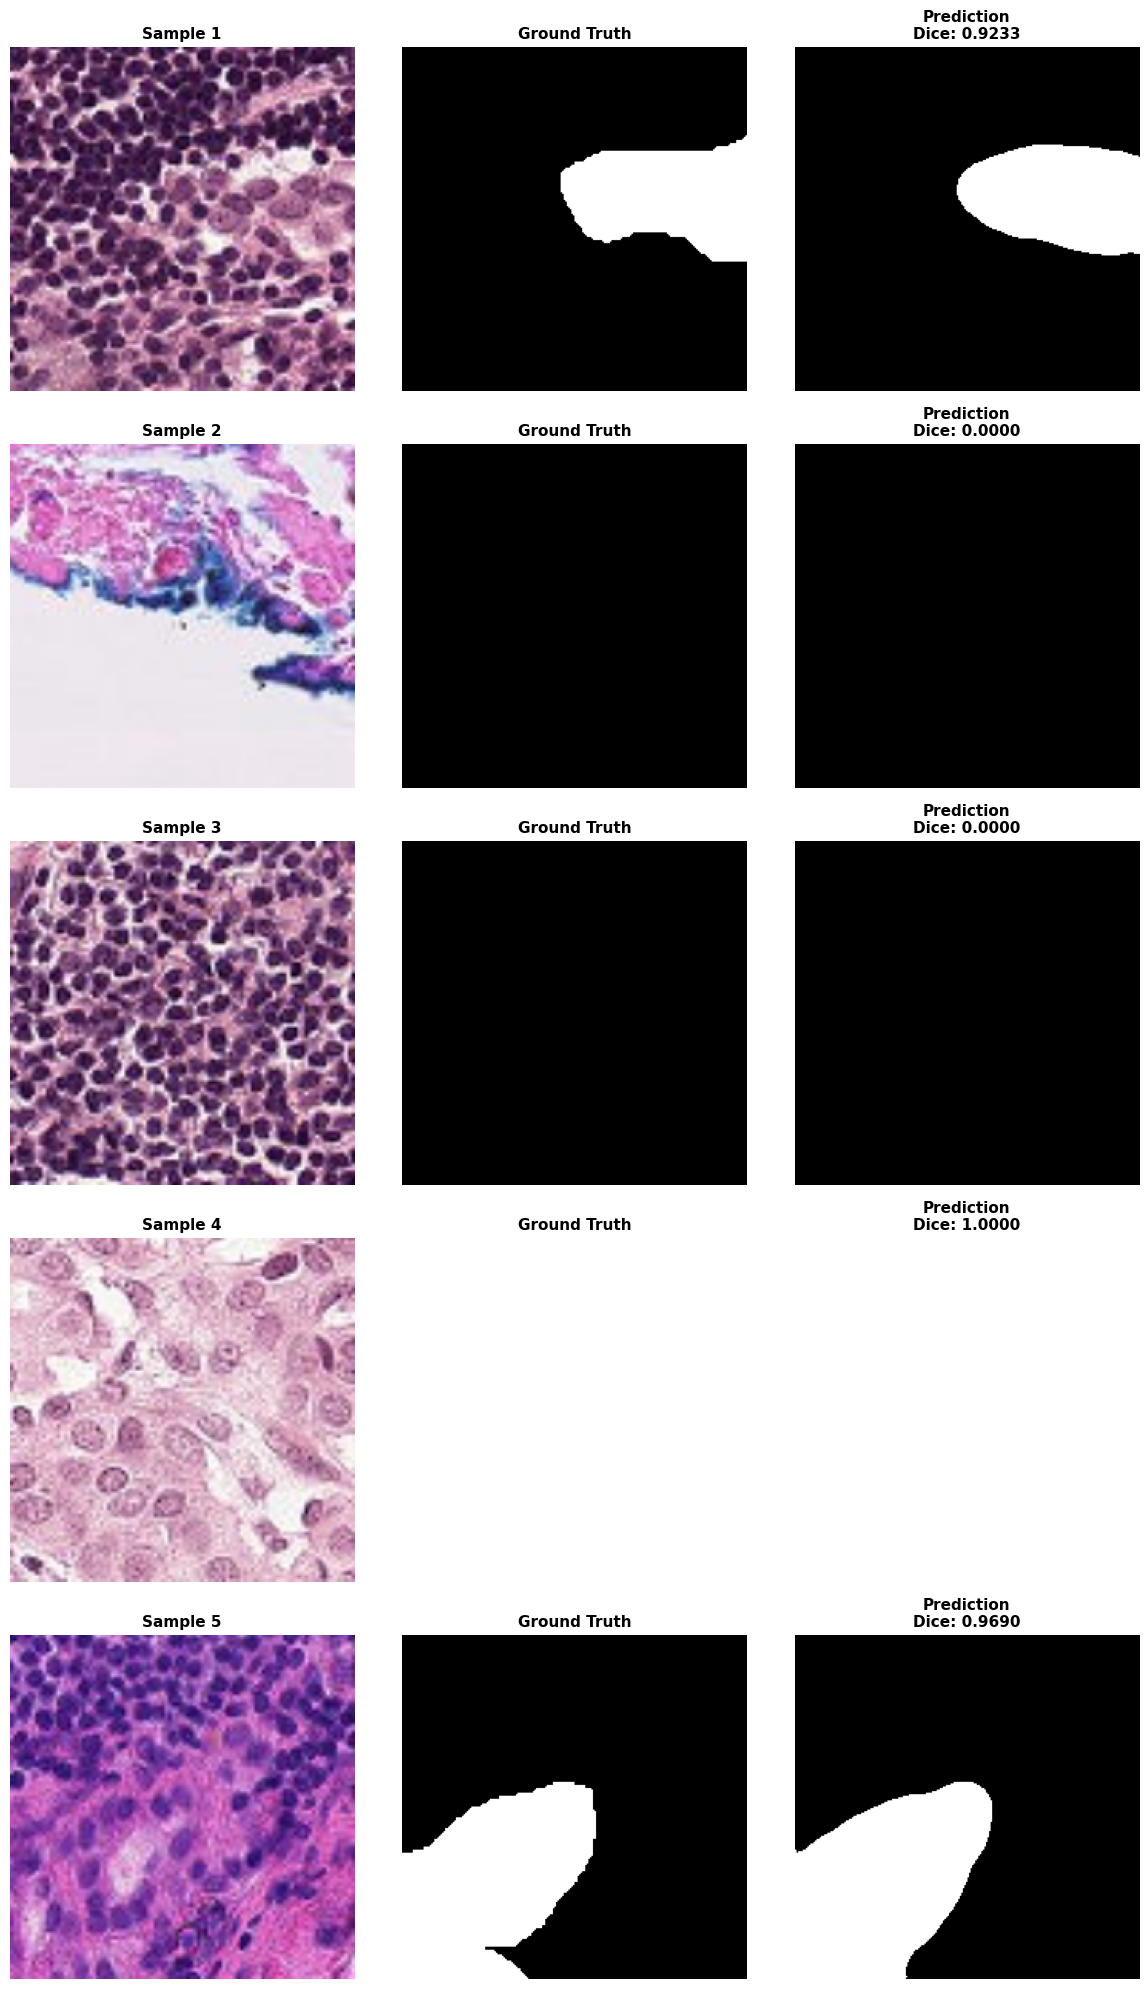

✅ Done! Random samples from test set visualized.


In [9]:
# -----------------------------------------------------------
# CELL 6: FAST RANDOM SAMPLES (NO LOADING ALL DATA)
# -----------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

print("🔮 Visualizing Random Segmentation Predictions...")

model.eval()
model = model.cpu()

# Get one random batch from test loader
batch_idx = random.randint(0, len(testloader)-1)
for i, (images, masks) in enumerate(testloader):
    if i == batch_idx:
        break

# Select 5 random samples from this batch
num_samples = min(5, len(images))
random_indices = random.sample(range(len(images)), num_samples)

# Run inference once for the whole batch
with torch.no_grad():
    logits = model(images)
    preds = torch.sigmoid(logits)
    pred_masks = (preds > 0.5).float()

# Create figure with WHITE background
fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
fig.patch.set_facecolor('white')

for plot_idx, img_idx in enumerate(random_indices):
    # Get data
    img_np = images[img_idx].permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)
    
    gt_mask = masks[img_idx].squeeze().numpy()
    pred_mask_np = pred_masks[img_idx].squeeze().numpy()
    
    # Calculate Dice
    intersection = (pred_mask_np * gt_mask).sum()
    union = pred_mask_np.sum() + gt_mask.sum()
    dice = (2. * intersection) / (union + 1e-8)
    
    # Plot
    axes[plot_idx, 0].imshow(img_np)
    axes[plot_idx, 0].set_title(f'Sample {plot_idx+1}', fontsize=11, fontweight='bold')
    axes[plot_idx, 0].axis('off')
    
    axes[plot_idx, 1].imshow(gt_mask, cmap='gray', vmin=0, vmax=1)
    axes[plot_idx, 1].set_title('Ground Truth', fontsize=11, fontweight='bold')
    axes[plot_idx, 1].axis('off')
    
    axes[plot_idx, 2].imshow(pred_mask_np, cmap='gray', vmin=0, vmax=1)
    axes[plot_idx, 2].set_title(f'Prediction\nDice: {dice:.4f}', fontsize=11, fontweight='bold')
    axes[plot_idx, 2].axis('off')

plt.tight_layout()
plt.savefig('random_samples_fast.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Done! Random samples from test set visualized.")


📊 Calculating Segmentation Metrics...
✅ Analyzed 1280 images (20 batches)


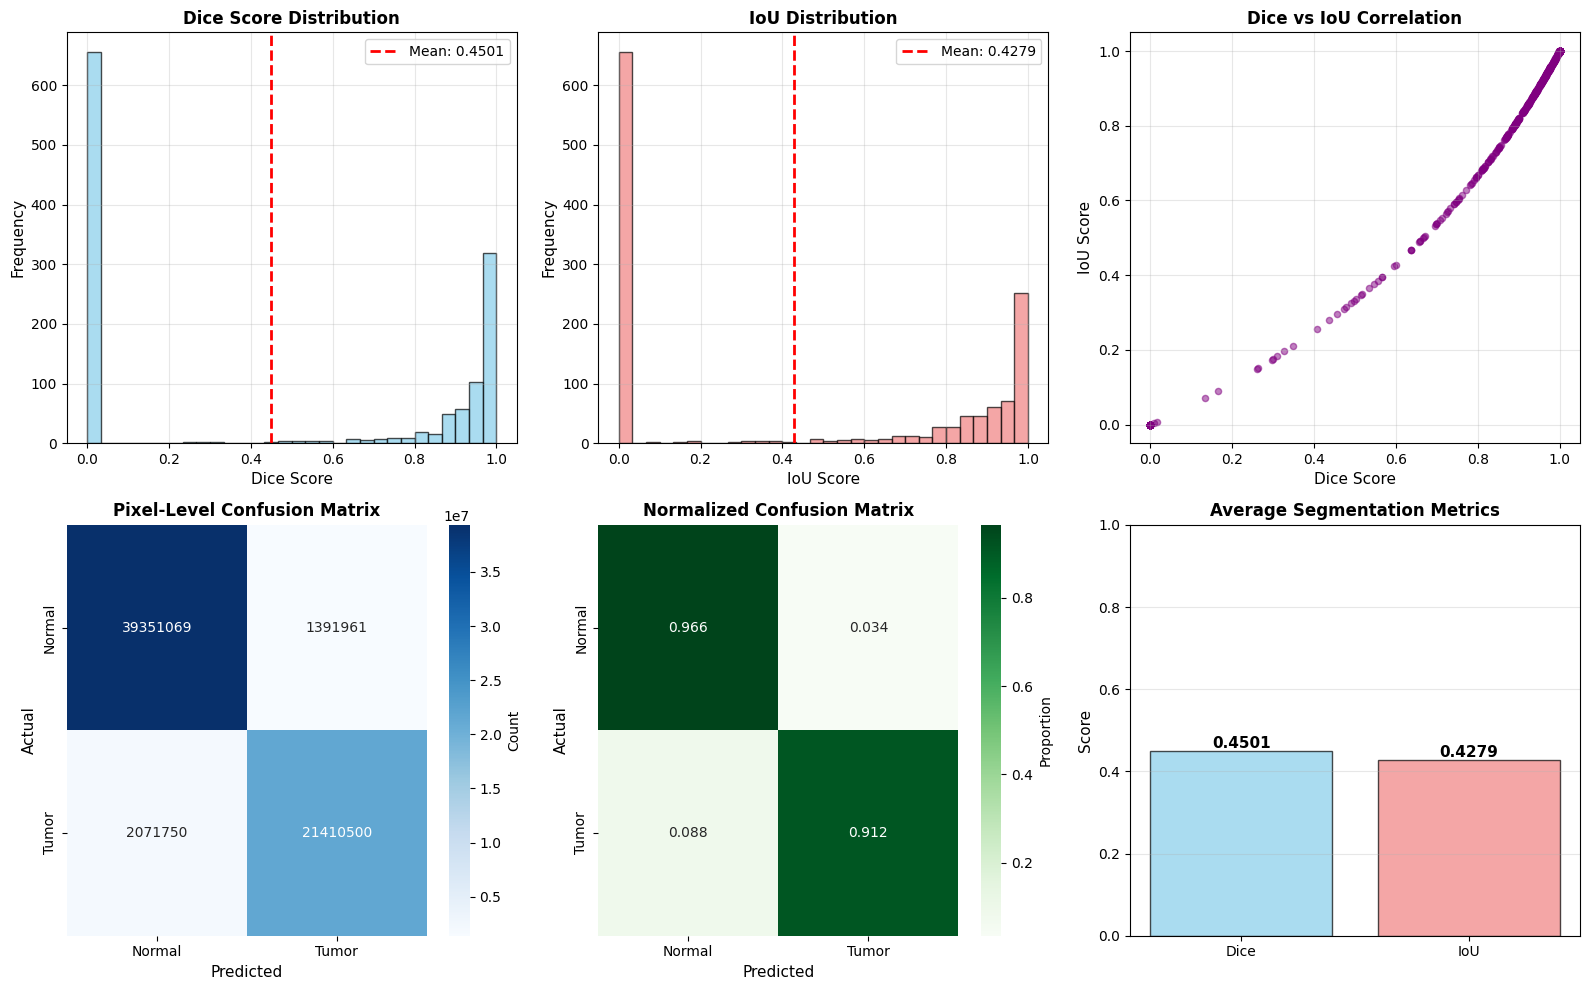


📊 SEGMENTATION PERFORMANCE SUMMARY
Images Analyzed:        1280
Total Pixels Analyzed:  64,225,280
----------------------------------------------------------------------
Mean Dice Score:        0.4501 ± 0.4702
Median Dice Score:      0.0000
Min Dice Score:         0.0000
Max Dice Score:         1.0000
----------------------------------------------------------------------
Mean IoU Score:         0.4279 ± 0.4548
Median IoU Score:       0.0000
----------------------------------------------------------------------

📝 Pixel-Level Classification Report:
               precision    recall  f1-score   support

Normal Tissue     0.9500    0.9658    0.9578  40743030
 Tumor Tissue     0.9390    0.9118    0.9252  23482250

     accuracy                         0.9461  64225280
    macro avg     0.9445    0.9388    0.9415  64225280
 weighted avg     0.9460    0.9461    0.9459  64225280

✅ Metrics saved as 'segmentation_metrics.png'


In [10]:
# -----------------------------------------------------------
# CELL 7: SEGMENTATION PERFORMANCE METRICS
# -----------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch

print("📊 Calculating Segmentation Metrics...")

# Setup
model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Limit batches for speed
LIMIT_BATCHES = 20

# Collect predictions
all_dice_scores = []
all_iou_scores = []
all_pixel_labels = []  # All pixels as individual samples
all_pixel_preds = []

with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(testloader):
        if batch_idx >= LIMIT_BATCHES:
            break
        
        images, masks = images.to(device), masks.to(device)
        
        # Inference
        logits = model(images)
        preds = torch.sigmoid(logits)
        pred_masks = (preds > 0.5).float()
        
        # Calculate per-image metrics
        for i in range(len(images)):
            pred = pred_masks[i].squeeze()
            gt = masks[i].squeeze()
            
            # Dice score
            intersection = (pred * gt).sum()
            union = pred.sum() + gt.sum()
            dice = (2. * intersection) / (union + 1e-8)
            all_dice_scores.append(dice.cpu().item())
            
            # IoU
            iou = intersection / (union - intersection + 1e-8)
            all_iou_scores.append(iou.cpu().item())
            
            # Collect pixel-level predictions for confusion matrix
            all_pixel_labels.extend(gt.cpu().flatten().numpy())
            all_pixel_preds.extend(pred.cpu().flatten().numpy())

print(f"✅ Analyzed {len(all_dice_scores)} images ({LIMIT_BATCHES} batches)")

# Convert to numpy
all_pixel_labels = np.array(all_pixel_labels).astype(int)
all_pixel_preds = np.array(all_pixel_preds).astype(int)

# Create visualizations
fig = plt.figure(figsize=(16, 10))
fig.patch.set_facecolor('white')

# 1. Dice Score Distribution
ax1 = plt.subplot(2, 3, 1)
ax1.hist(all_dice_scores, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax1.axvline(np.mean(all_dice_scores), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {np.mean(all_dice_scores):.4f}')
ax1.set_xlabel('Dice Score', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Dice Score Distribution', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. IoU Distribution
ax2 = plt.subplot(2, 3, 2)
ax2.hist(all_iou_scores, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
ax2.axvline(np.mean(all_iou_scores), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {np.mean(all_iou_scores):.4f}')
ax2.set_xlabel('IoU Score', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('IoU Distribution', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Dice vs IoU Scatter
ax3 = plt.subplot(2, 3, 3)
ax3.scatter(all_dice_scores, all_iou_scores, alpha=0.5, c='purple', s=20)
ax3.set_xlabel('Dice Score', fontsize=11)
ax3.set_ylabel('IoU Score', fontsize=11)
ax3.set_title('Dice vs IoU Correlation', fontsize=12, fontweight='bold')
ax3.grid(alpha=0.3)

# 4. Pixel-Level Confusion Matrix
cm = confusion_matrix(all_pixel_labels, all_pixel_preds)
ax4 = plt.subplot(2, 3, 4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Tumor'],
            yticklabels=['Normal', 'Tumor'],
            ax=ax4, cbar_kws={'label': 'Count'})
ax4.set_xlabel('Predicted', fontsize=11)
ax4.set_ylabel('Actual', fontsize=11)
ax4.set_title('Pixel-Level Confusion Matrix', fontsize=12, fontweight='bold')

# 5. Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
ax5 = plt.subplot(2, 3, 5)
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Greens',
            xticklabels=['Normal', 'Tumor'],
            yticklabels=['Normal', 'Tumor'],
            ax=ax5, cbar_kws={'label': 'Proportion'})
ax5.set_xlabel('Predicted', fontsize=11)
ax5.set_ylabel('Actual', fontsize=11)
ax5.set_title('Normalized Confusion Matrix', fontsize=12, fontweight='bold')

# 6. Performance Summary Bar Chart
ax6 = plt.subplot(2, 3, 6)
metrics = ['Dice', 'IoU']
values = [np.mean(all_dice_scores), np.mean(all_iou_scores)]
colors = ['skyblue', 'lightcoral']
bars = ax6.bar(metrics, values, color=colors, edgecolor='black', alpha=0.7)
ax6.set_ylabel('Score', fontsize=11)
ax6.set_ylim([0, 1])
ax6.set_title('Average Segmentation Metrics', fontsize=12, fontweight='bold')
ax6.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('segmentation_metrics.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# Print detailed statistics
print("\n" + "="*70)
print("📊 SEGMENTATION PERFORMANCE SUMMARY")
print("="*70)
print(f"Images Analyzed:        {len(all_dice_scores)}")
print(f"Total Pixels Analyzed:  {len(all_pixel_labels):,}")
print("-"*70)
print(f"Mean Dice Score:        {np.mean(all_dice_scores):.4f} ± {np.std(all_dice_scores):.4f}")
print(f"Median Dice Score:      {np.median(all_dice_scores):.4f}")
print(f"Min Dice Score:         {np.min(all_dice_scores):.4f}")
print(f"Max Dice Score:         {np.max(all_dice_scores):.4f}")
print("-"*70)
print(f"Mean IoU Score:         {np.mean(all_iou_scores):.4f} ± {np.std(all_iou_scores):.4f}")
print(f"Median IoU Score:       {np.median(all_iou_scores):.4f}")
print("-"*70)

# Pixel-level classification report
print("\n📝 Pixel-Level Classification Report:")
print(classification_report(all_pixel_labels, all_pixel_preds, 
                          target_names=['Normal Tissue', 'Tumor Tissue'],
                          digits=4))

print("="*70)
print("✅ Metrics saved as 'segmentation_metrics.png'")


🔮 Loading model and generating heatmaps...
📁 Loading: /kaggle/working/checkpoints/best_hybrid_unet.ckpt


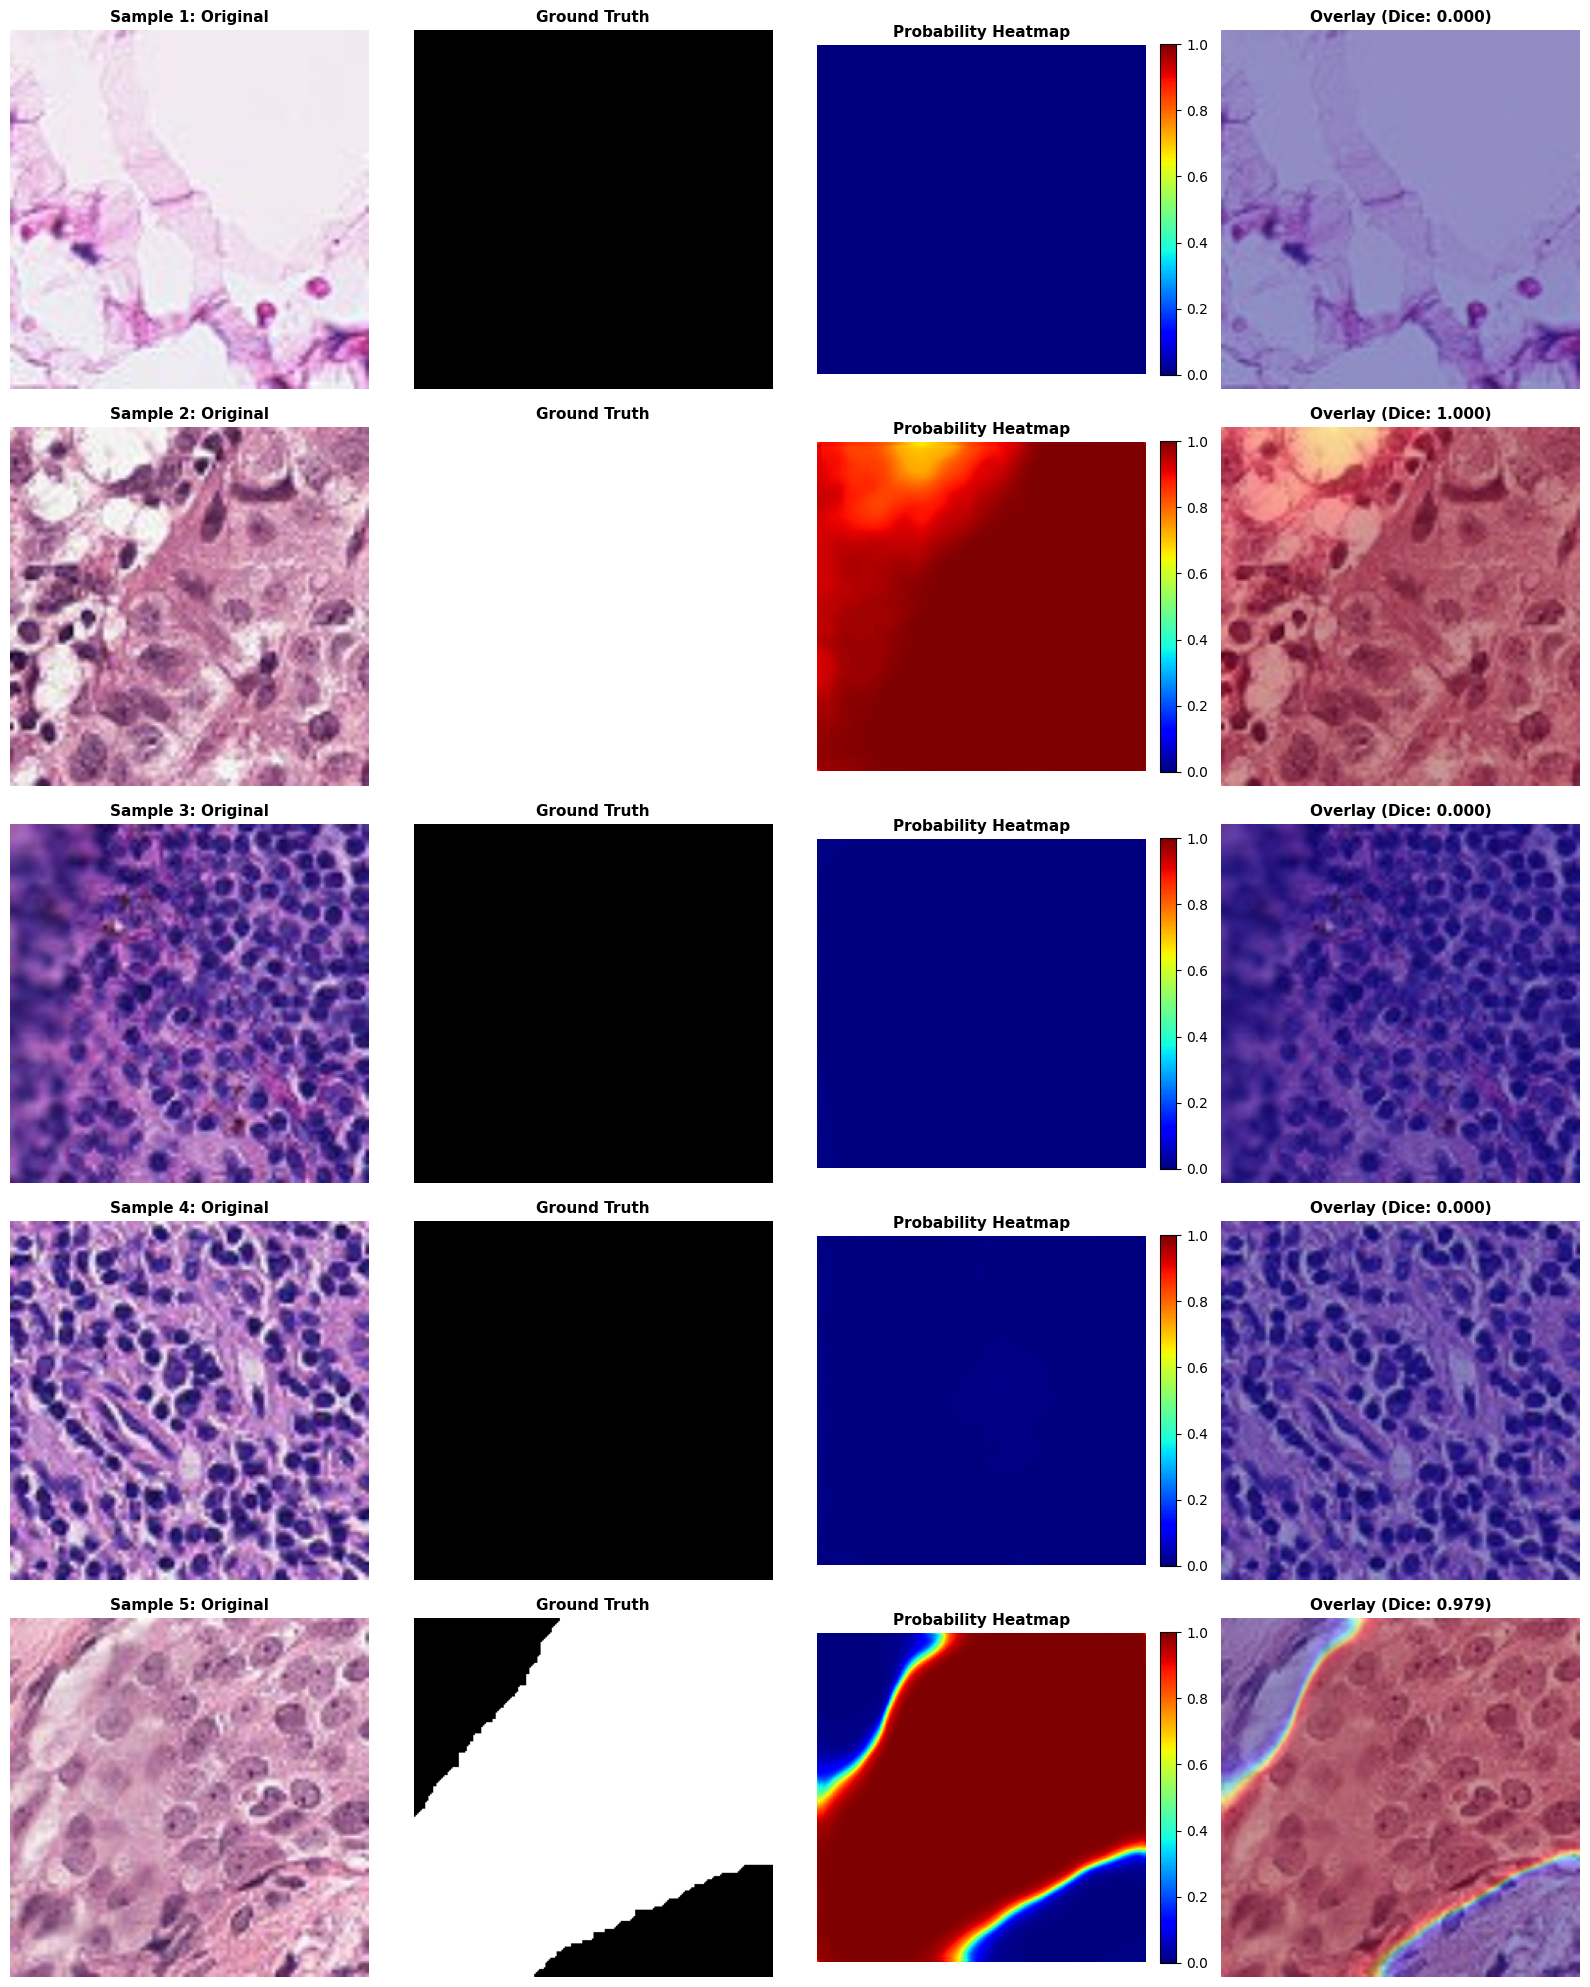

✅ Heatmap visualization saved as 'tumor_heatmaps.png'
🔥 Hot colors (red/yellow) = High tumor probability
❄️  Cool colors (blue) = Low tumor probability


In [11]:
# -----------------------------------------------------------
# CELL 8: HEATMAP VISUALIZATION (WITH MODEL RELOAD)
# -----------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import glob
import os

print("🔮 Loading model and generating heatmaps...")

# 1. Reload the model
basedir = os.getcwd()
ckpt_folder = os.path.join(basedir, "checkpoints")
checkpoint_files = glob.glob(os.path.join(ckpt_folder, "*.ckpt"))

if not checkpoint_files:
    raise FileNotFoundError("No checkpoint found!")

best_model_path = max(checkpoint_files, key=os.path.getctime)
print(f"📁 Loading: {best_model_path}")

# Load model
model = MobileNetUNet.load_from_checkpoint(best_model_path)
model.eval()
model = model.cpu()

# 2. Get test batch
images, masks = next(iter(testloader))

# 3. Run inference
with torch.no_grad():
    logits = model(images)
    probs = torch.sigmoid(logits)  # Probability map [0,1]

# 4. Visualize 5 samples
num_samples = min(5, len(images))
fig = plt.figure(figsize=(16, 4*num_samples))
fig.patch.set_facecolor('white')

for i in range(num_samples):
    # Get data
    img = images[i].permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    gt_mask = masks[i].squeeze().numpy()
    prob_map = probs[i].squeeze().numpy()
    
    # Create heatmap overlay
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * prob_map), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0
    
    # Overlay on original image
    overlay = 0.6 * img + 0.4 * heatmap_colored
    
    # Calculate Dice
    pred_binary = (prob_map > 0.5).astype(float)
    intersection = (pred_binary * gt_mask).sum()
    union = pred_binary.sum() + gt_mask.sum()
    dice = (2. * intersection) / (union + 1e-8)
    
    # Plot 4 columns
    # 1. Original Image
    ax1 = plt.subplot(num_samples, 4, i*4 + 1)
    ax1.imshow(img)
    ax1.set_title(f'Sample {i+1}: Original', fontsize=11, fontweight='bold')
    ax1.axis('off')
    
    # 2. Ground Truth
    ax2 = plt.subplot(num_samples, 4, i*4 + 2)
    ax2.imshow(gt_mask, cmap='gray', vmin=0, vmax=1)
    ax2.set_title('Ground Truth', fontsize=11, fontweight='bold')
    ax2.axis('off')
    
    # 3. Probability Heatmap
    ax3 = plt.subplot(num_samples, 4, i*4 + 3)
    im = ax3.imshow(prob_map, cmap='jet', vmin=0, vmax=1)
    ax3.set_title(f'Probability Heatmap', fontsize=11, fontweight='bold')
    ax3.axis('off')
    plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
    
    # 4. Overlay
    ax4 = plt.subplot(num_samples, 4, i*4 + 4)
    ax4.imshow(overlay)
    ax4.set_title(f'Overlay (Dice: {dice:.3f})', fontsize=11, fontweight='bold')
    ax4.axis('off')

plt.tight_layout()
plt.savefig('tumor_heatmaps.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Heatmap visualization saved as 'tumor_heatmaps.png'")
print("🔥 Hot colors (red/yellow) = High tumor probability")
print("❄️  Cool colors (blue) = Low tumor probability")


🔮 Creating Composite Grid Heatmap...
📁 Loading: /kaggle/working/checkpoints/best_hybrid_unet.ckpt
✅ Processing 16 samples in 4×4 grid...
🔨 Stitching images into composite grids...


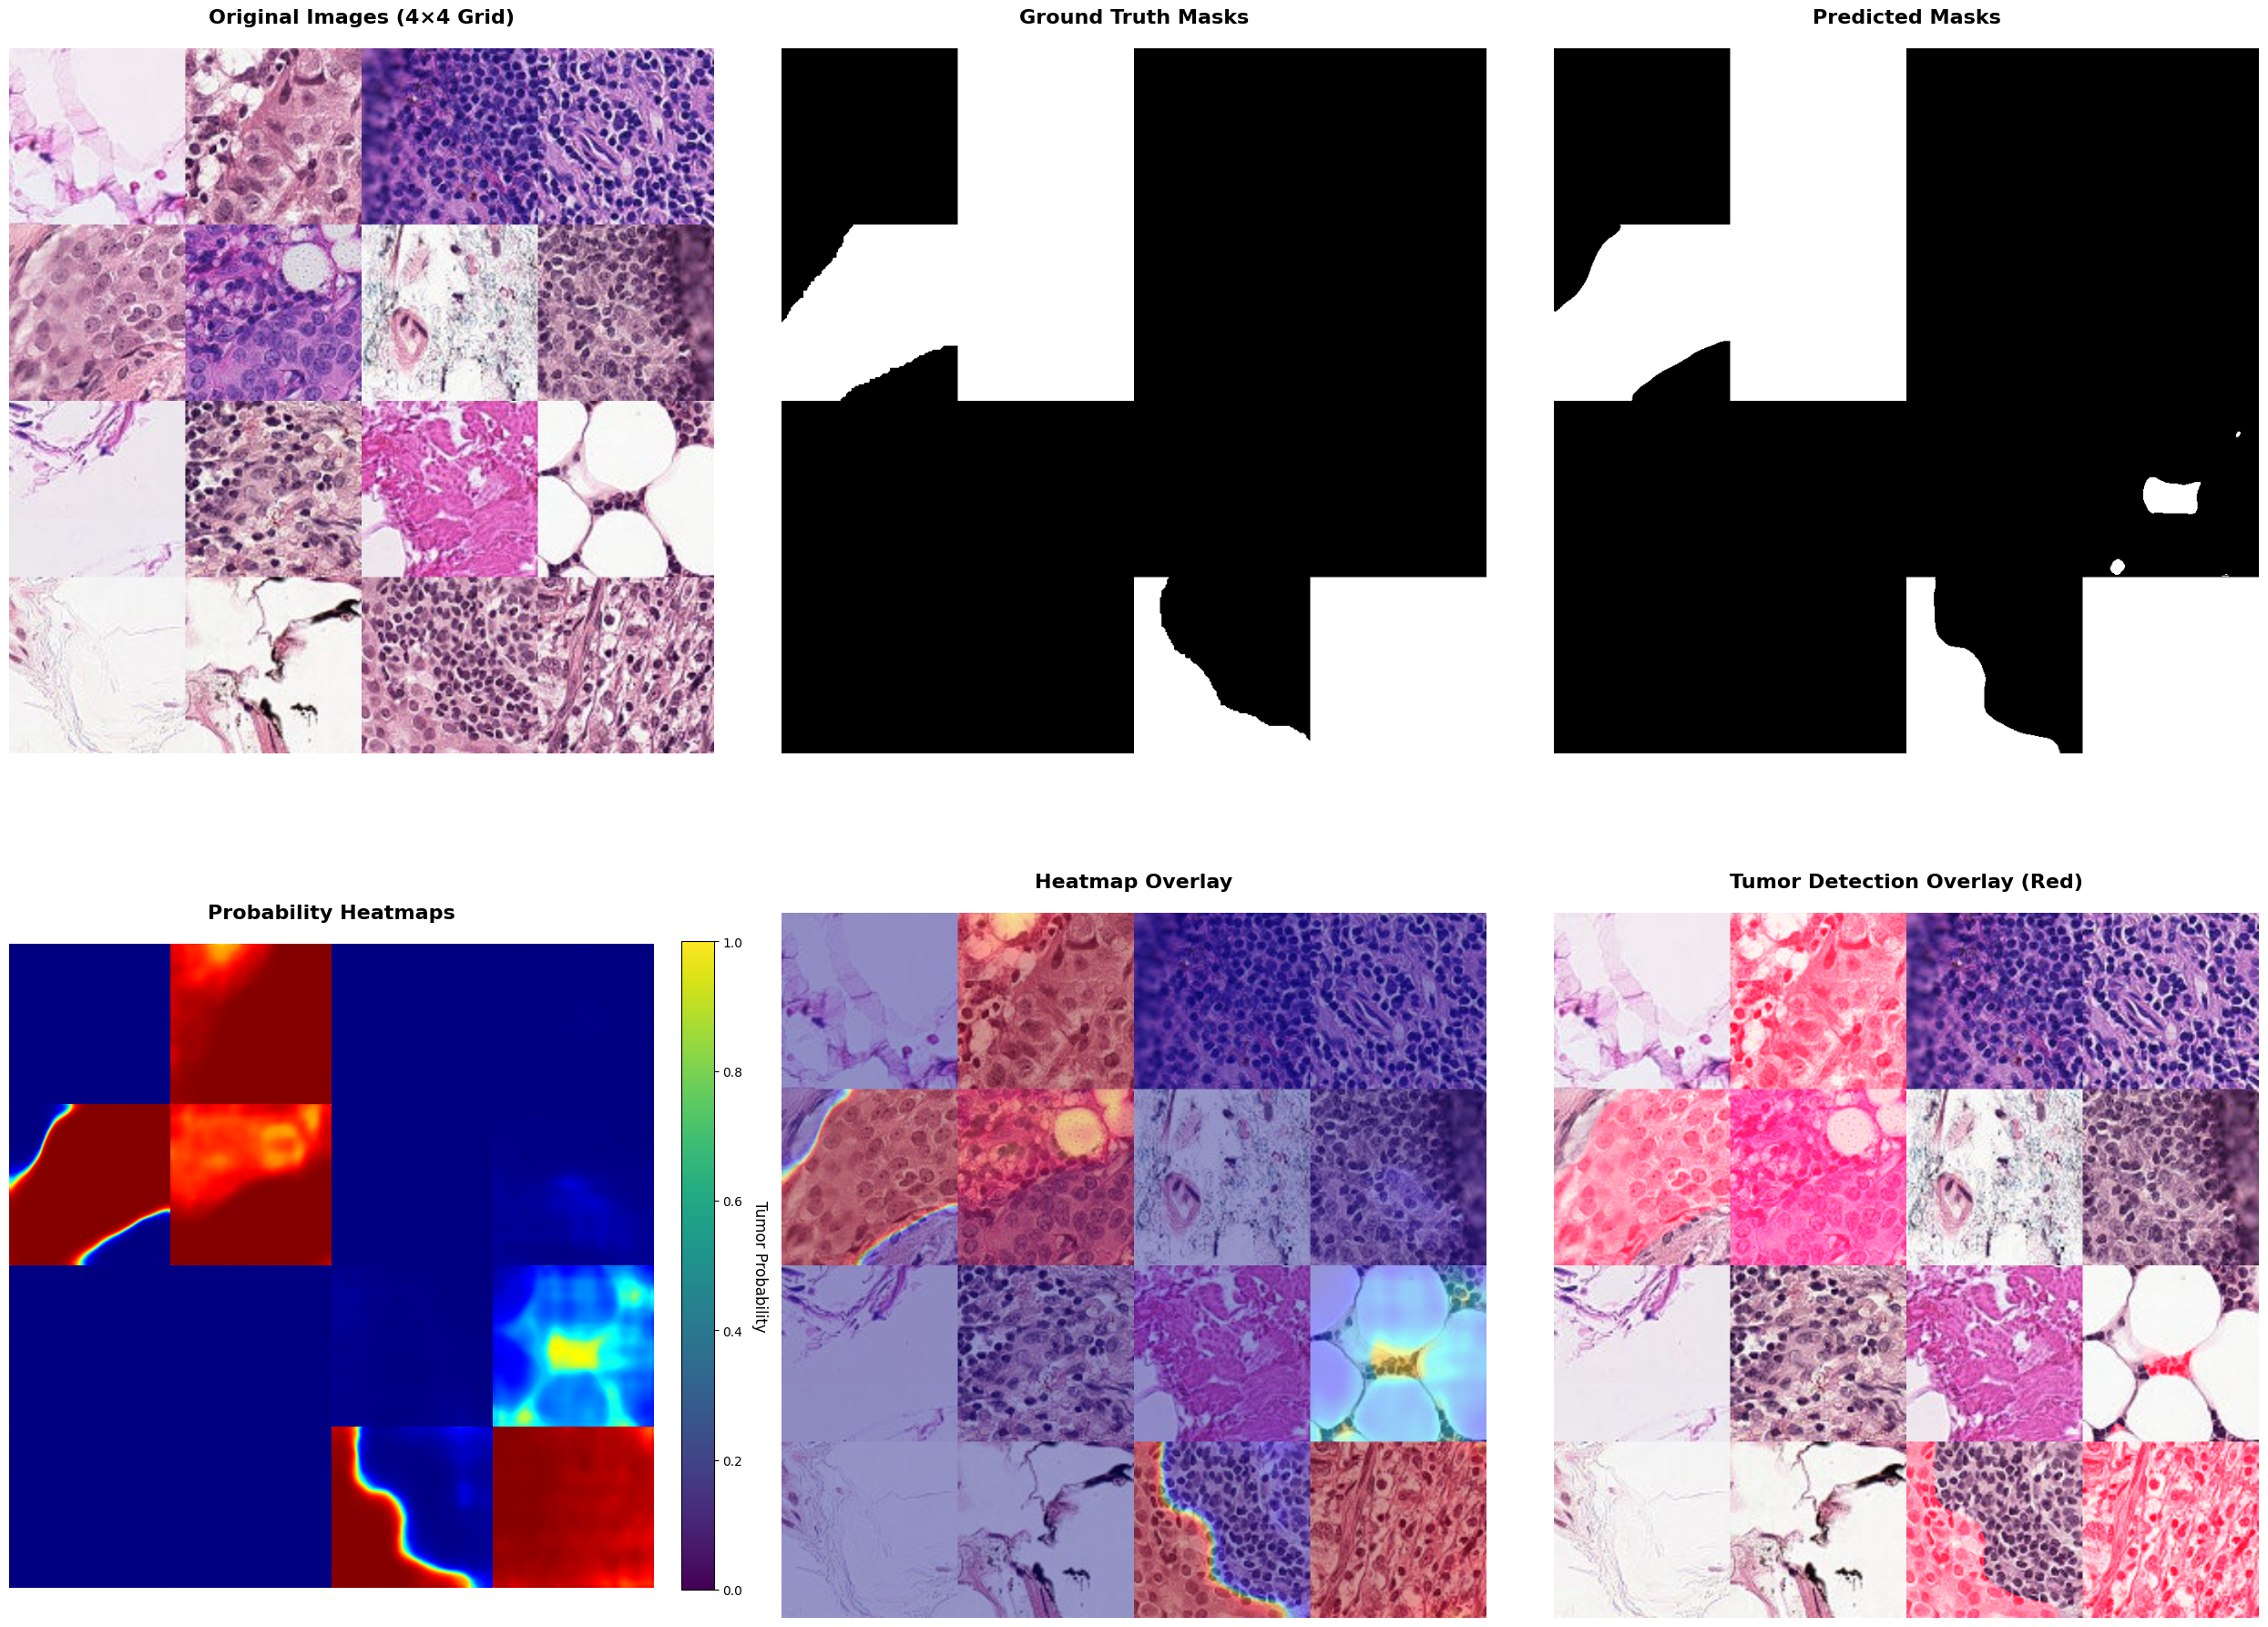

✅ Composite grid visualization saved!
📊 Grid size: 4×4 = 16 samples
📁 Saved as: composite_grid_heatmap.png


In [12]:
# -----------------------------------------------------------
# CELL 8: COMPOSITE GRID HEATMAP VISUALIZATION
# -----------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import glob
import os

print("🔮 Creating Composite Grid Heatmap...")

# 1. Reload model
basedir = os.getcwd()
ckpt_folder = os.path.join(basedir, "checkpoints")
checkpoint_files = glob.glob(os.path.join(ckpt_folder, "*.ckpt"))

if not checkpoint_files:
    raise FileNotFoundError("No checkpoint found!")

best_model_path = max(checkpoint_files, key=os.path.getctime)
print(f"📁 Loading: {best_model_path}")

model = MobileNetUNet.load_from_checkpoint(best_model_path)
model.eval()
model = model.cpu()

# 2. Get samples
images, masks = next(iter(testloader))

# Configuration: Number of samples to display
GRID_SIZE = 4  # 4x4 = 16 samples (can change to 5 for 5x5 = 25 samples)
NUM_SAMPLES = GRID_SIZE * GRID_SIZE

# Take first N samples
images = images[:NUM_SAMPLES]
masks = masks[:NUM_SAMPLES]

# 3. Run inference
with torch.no_grad():
    logits = model(images)
    probs = torch.sigmoid(logits)
    pred_masks = (probs > 0.5).float()

print(f"✅ Processing {NUM_SAMPLES} samples in {GRID_SIZE}×{GRID_SIZE} grid...")

# 4. Create composite images
def create_composite_grid(images_list, grid_size):
    """Stitch images into a single grid"""
    h, w = images_list[0].shape[:2]
    if len(images_list[0].shape) == 3:
        composite = np.zeros((h * grid_size, w * grid_size, 3))
    else:
        composite = np.zeros((h * grid_size, w * grid_size))
    
    for idx in range(len(images_list)):
        row = idx // grid_size
        col = idx % grid_size
        composite[row*h:(row+1)*h, col*w:(col+1)*w] = images_list[idx]
    
    return composite

# Prepare all images
original_patches = []
ground_truth_patches = []
prediction_patches = []
heatmap_patches = []
overlay_patches = []

for i in range(NUM_SAMPLES):
    # Original image
    img = images[i].permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    original_patches.append(img)
    
    # Ground truth mask
    gt_mask = masks[i].squeeze().numpy()
    gt_rgb = np.stack([gt_mask]*3, axis=-1)  # Convert to RGB
    ground_truth_patches.append(gt_rgb)
    
    # Prediction mask
    pred_mask = pred_masks[i].squeeze().numpy()
    pred_rgb = np.stack([pred_mask]*3, axis=-1)
    prediction_patches.append(pred_rgb)
    
    # Heatmap (probability map)
    prob_map = probs[i].squeeze().numpy()
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * prob_map), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0
    heatmap_patches.append(heatmap_colored)
    
    # Overlay
    overlay = 0.6 * img + 0.4 * heatmap_colored
    overlay_patches.append(overlay)

# 5. Create composite images
print("🔨 Stitching images into composite grids...")
composite_original = create_composite_grid(original_patches, GRID_SIZE)
composite_ground_truth = create_composite_grid(ground_truth_patches, GRID_SIZE)
composite_prediction = create_composite_grid(prediction_patches, GRID_SIZE)
composite_heatmap = create_composite_grid(heatmap_patches, GRID_SIZE)
composite_overlay = create_composite_grid(overlay_patches, GRID_SIZE)

# 6. Visualize all composites
fig = plt.figure(figsize=(25, 20))
fig.patch.set_facecolor('white')

# Original Images Grid
ax1 = plt.subplot(2, 3, 1)
ax1.imshow(composite_original)
ax1.set_title(f'Original Images ({GRID_SIZE}×{GRID_SIZE} Grid)', 
              fontsize=16, fontweight='bold', pad=20)
ax1.axis('off')

# Ground Truth Grid
ax2 = plt.subplot(2, 3, 2)
ax2.imshow(composite_ground_truth, cmap='gray')
ax2.set_title(f'Ground Truth Masks', 
              fontsize=16, fontweight='bold', pad=20)
ax2.axis('off')

# Prediction Grid
ax3 = plt.subplot(2, 3, 3)
ax3.imshow(composite_prediction, cmap='gray')
ax3.set_title(f'Predicted Masks', 
              fontsize=16, fontweight='bold', pad=20)
ax3.axis('off')

# Heatmap Grid
ax4 = plt.subplot(2, 3, 4)
im = ax4.imshow(composite_heatmap)
ax4.set_title(f'Probability Heatmaps', 
              fontsize=16, fontweight='bold', pad=20)
ax4.axis('off')
# Add colorbar
cbar = plt.colorbar(im, ax=ax4, fraction=0.046, pad=0.04)
cbar.set_label('Tumor Probability', rotation=270, labelpad=20, fontsize=12)

# Overlay Grid
ax5 = plt.subplot(2, 3, 5)
ax5.imshow(composite_overlay)
ax5.set_title(f'Heatmap Overlay', 
              fontsize=16, fontweight='bold', pad=20)
ax5.axis('off')

# Patch Overlay (red tumor boundaries)
composite_patch_overlay = composite_original.copy()
composite_patch_overlay[:, :, 0] = np.where(
    create_composite_grid([pred_masks[i].squeeze().numpy() for i in range(NUM_SAMPLES)], GRID_SIZE) > 0.5,
    1.0,
    composite_patch_overlay[:, :, 0]
)
ax6 = plt.subplot(2, 3, 6)
ax6.imshow(composite_patch_overlay)
ax6.set_title(f'Tumor Detection Overlay (Red)', 
              fontsize=16, fontweight='bold', pad=20)
ax6.axis('off')

plt.tight_layout()
plt.savefig('composite_grid_heatmap.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Composite grid visualization saved!")
print(f"📊 Grid size: {GRID_SIZE}×{GRID_SIZE} = {NUM_SAMPLES} samples")
print("📁 Saved as: composite_grid_heatmap.png")
